##**SENTIMENT ANALYSIS: POLARITY CLASSIFICATION WITH SUBJECTIVITY DETECTION**
This baseline implement a workflow to perform the polarity classification on the movie review dataset. The performance is improved by a subjectivity detection task 

In [1]:
import numpy as np
import time
import pickle
from random import shuffle 
import nltk
import string

from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.corpus import sentiwordnet
from nltk.corpus import stopwords
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn import naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from nltk.corpus import movie_reviews
from nltk.corpus import subjectivity
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

#importing dataset nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('movie_reviews')
nltk.download('subjectivity')

nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package subjectivity to /root/nltk_data...
[nltk_data]   Unzipping corpora/subjectivity.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

#**Dataset preprocessing steps**
The dataset need to be preprocessed in order to remove every elements that will not help the classification. Then the following steps are done:

*   remove punctuation
*   tokenization
*   remove stopwords
*   pos tagging 
*   obtain stem words with lemmatization





In [2]:
#function to clean the texts

#take in input sent subdivide in tokens and remove puctuations and stopwords
def remove_punct_stopwords(tokens_list):
  stop_words = stopwords.words('english')
  punctuation = string.punctuation

  #control on lowercase
  filtered_tokens = [word.lower() for word in tokens_list if word.lower() not in stop_words and word not in punctuation]
  return filtered_tokens

def neg_mark(tokens_list):
  #handling negation mark
  suffix = "_neg";
  check_neg =[]
  for token in tokens_list:
    check_neg.append(token.endswith(suffix))
  return check_neg

#Obtain the word stem -> responsible for lexical meaning
#pos tagging token identification to prepare for lemmatization
def pos_tagging_lemmatizer(tokens_list, neg_list):

  tags = pos_tag(tokens_list)

  #lemmatization of the tokens list using pos-tags
  lemmatizer = WordNetLemmatizer()
  lemmatized_list = []

  #to use wordnet lemmatizer convert the treebank tags to WordNet POS
  for word, tag in tags:

        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        elif tag.startswith('ADV'):
            pos = 'r'
        elif tag.startswith('ADJ'):
            pos = 'j'
        else:
            pos = 'a'

        lemmatized_list.append(lemmatizer.lemmatize(word, pos))
  
  lemmatize_neg = []
  check_neg = neg_mark(neg_list)
  for i in range(len(lemmatized_list)):
    if(check_neg[i]):
      lemmatize_neg.append(neg_list[i])
    else:
      lemmatize_neg.append(lemmatized_list[i])
  #return lemmatized_list to not including the negation handling
  return lemmatize_neg

##Handling negations
Negations were handled with the negation mark _NEG by calling the method mark_negation from the nltk library. The original version associate the mark to all the following tokens, but in this case was taken into account only the next token.
The function from the nltk library was modified as following.

This will create a word with is the opposite meaning that can help to improve the features extraction and then the performance of the classifier.  

In [3]:
#modify the function of mark_negation to handle only the next word
#SEE -> https://www.nltk.org/_modules/nltk/sentiment/util.html

from copy import deepcopy
import re 

# Regular expression for negation by Christopher Potts
NEGATION = r"""
    (?:
        ^(?:never|no|nothing|nowhere|noone|none|not|
            havent|hasnt|hadnt|cant|couldnt|shouldnt|
            wont|wouldnt|dont|doesnt|didnt|isnt|arent|aint
        )$
    )
    |
    n't"""

NEGATION_RE = re.compile(NEGATION, re.VERBOSE)

CLAUSE_PUNCT = r"^[.:;!?]$"
CLAUSE_PUNCT_RE = re.compile(CLAUSE_PUNCT)

def mark_negation(document, double_neg_flip=False, shallow=False):
    if not shallow:
        document = deepcopy(document)
    # check if the document is labeled. If so, do not consider the label.
    labeled = document and isinstance(document[0], (tuple, list))
    if labeled:
        doc = document[0]
    else:
        doc = document
    neg_scope = False
    for i, word in enumerate(doc):
        if NEGATION_RE.search(word):
            if not neg_scope or (neg_scope and double_neg_flip):
                neg_scope = not neg_scope
                continue
            else:
                doc[i] += "_NEG"
                #exit after the first word marked
                break
        elif neg_scope and CLAUSE_PUNCT_RE.search(word):
            neg_scope = not neg_scope
        elif neg_scope and not CLAUSE_PUNCT_RE.search(word):
            doc[i] += "_NEG"
            #exit after the first word marked
            break

    return document

In [4]:
def filtered_sent(tokens, neg_list):
  #call the functions to clean each sent
  tokens = remove_punct_stopwords(tokens)
  #take into accoun the negation of the next word, keep in memory the position
  neg_list = remove_punct_stopwords(neg_list)
  #substitute the lemma word with the corresponding negate word
  tokens = pos_tagging_lemmatizer(tokens,neg_list)
  return tokens

#from the dataset -> generate a list of filtered sents
def generate_sents(ids):
  filtered_list = []
  for i in range(1000):
    sents = movie_reviews.sents(fileids=ids[i])
    filtered_list.append(sents)
  return filtered_list

In [5]:
#prepare the two datasets

#----------MOVIE REVIEW------------
#list of sentences of each review, each sentence is divided in words
neg_reviews = generate_sents(movie_reviews.fileids('neg'))
pos_reviews = generate_sents(movie_reviews.fileids('pos'))
print(len(neg_reviews), len(pos_reviews))

print("--------------------------------------")

#-----------SUBJECTIVITY------------
#dataset of subjectivity, list of sentences
obj_sents = [sent for sent in subjectivity.sents(categories='obj')]
subj_sents = [sent for sent in subjectivity.sents(categories='subj')]
print(len(obj_sents), len(subj_sents))

1000 1000
--------------------------------------
5000 5000


#**Subjectivity Detection**
To perform subjectivity detection, the chosen model will be trained with the subjectivity dataset. The movie review dataset will be evaluated at the sentence level to differentiate between subjective and objective sentences. Consequentially, objective sentences will be removed according to a certain criterion.

More than one model were trained to complete this task:

*   Naive Bayes
*   SVM
*   LogisticRegression





In [6]:
#This function use cross validation

def subjectivity_detector_cross_val(X_train, X_test, y_train, y_test,vector_choose, model, ngrams):
  #Their are many methods to convert text data to vectors which the model can understand
  #TF-IDF or CountVectorizer

  # instantiate the vectorizer object
  if vector_choose == 1:
    #choose this with min = 1 to have the standard bow, count the freq of each word in the doc
    vectorizer = CountVectorizer(min_df=1, tokenizer=nltk.word_tokenize,ngram_range=(1,ngrams),stop_words='english')
  else:
    #use the inverse to enhance more specific word in the text
    vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(1,ngrams))

  classifier = model 

  #cross validation to all dataset,  so train+test
  vectors = vectorizer.fit_transform(X_train + X_test)

  scores = cross_validate(classifier, vectors, y_train + y_test, cv=StratifiedKFold(n_splits=5) , scoring=['accuracy'])
  average = sum(scores['test_accuracy'])/len(scores['test_accuracy'])
  print("Resulting accuracy average: ", round(average, 3))


**Features**

The Feature representation is defined with different tools: 


*   CountVectorizer
*   TfidfVectorizer

The first one is used as a baseline, where if min = 1, then it is considered a standard bag of words. The second one enhances words that are more specific in the text by giving them more importance.

**Ngrams**

The ngrams range is defined with ngram_range=(1, ngrams), where the variable ngrams is set to 3. In this case, we are taking into consideration unigrams, bigrams, and trigrams; other tests were done with different ranges.

In [7]:
#function subjectivity detection

def subjectivity_detector(X_train, X_test, y_train, y_test, vector_choose, ngrams):
  #use TD-IDF Vectorizer or CountVectorizer

  # instantiate the vectorizer object
  if vector_choose == 1:
    #choose this with min = 1 to have the standard bow, count the freq of each word in the doc
    vectorizer = CountVectorizer(min_df=1, tokenizer=nltk.word_tokenize,ngram_range=(1,ngrams),stop_words='english')
  else:
    #this one associate frequency of words with weigth, give more importance to the less frequent 
    vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(1,ngrams))

  X_train_vec = vectorizer.fit_transform(X_train)
  X_test_vec = vectorizer.transform(X_test)

  # Classifier - Algorithm - NaiveBayes
  # fit the training dataset on the NB classifier
  start_time =time.time()
  Naive = MultinomialNB()
  Naive.fit(X_train_vec,y_train)
  # predict the labels on validation dataset
  y_test_pred_NB = Naive.predict(X_test_vec)
  # Use accuracy_score function to get the accuracy
  print("Naive Bayes Accuracy Score -> ",accuracy_score(y_test_pred_NB, y_test)*100)
  print(classification_report(y_test, y_test_pred_NB,output_dict=True))
  print("------------------- %s seconds ------------------------" % (time.time() - start_time))
  print("--------------------------------------")

  # Classifier - Algorithm - SVM
  # fit the training dataset on the svm classifier
  start_time =time.time()
  SVM = svm.SVC(kernel='linear', probability=True, gamma='auto')
  SVM.fit(X_train_vec,y_train)
  # predict the labels on validation dataset
  y_test_pred_svm = SVM.predict(X_test_vec)
  # Use accuracy_score function to get the accuracy
  print("SVM Accuracy Score -> ",accuracy_score(y_test_pred_svm, y_test)*100)
  print(classification_report(y_test, y_test_pred_svm,output_dict=True))
  print("------------------- %s seconds ------------------------" % (time.time() - start_time))
  print("--------------------------------------")

  # Classifier - Algorithm - LogisticRegression
  # fit the training dataset on the Log classifier
  start_time =time.time()
  Log = LogisticRegression(max_iter=1000)
  Log.fit(X_train_vec,y_train)
  # predict the labels on validation dataset
  y_test_pred_log = Log.predict(X_test_vec)
  # Use accuracy_score function to get the accuracy
  print("LogisticRegression Accuracy Score -> ",accuracy_score(y_test_pred_log, y_test)*100)
  print(classification_report(y_test, y_test_pred_log,output_dict=True))
  print("------------------- %s seconds ------------------------" % (time.time() - start_time))


In [8]:
#function to prepare train set and test set for the classification
def data_split(split_number, doc_c1, doc_c2):

  #split dataset in 80 / 20
  split = int(80*split_number/100)

  #equi subdivided dataset of classes c1 and c2
  train_set = doc_c1[:split] + doc_c2[:split]
  test_set = doc_c1[split:] + doc_c2[split:]

  #words
  X_train = [' '.join(words) for (words, label) in train_set]
  X_test = [' '.join(words) for (words, label) in test_set]
  #labels
  y_train = [label for (words, label) in train_set]
  y_test = [label for (words, label) in test_set]

  return X_train, X_test, y_train, y_test


##Testing on the subjectivity dataset
In this section the subjectivity detection task is trained and tested only on the subjetivity dataset. The goal of this test is to choose the best model to ultimately train the detector.


In [9]:
###testing on subjectivity dataset only###

print("Testing on subjectivity dataset only")
clean_subj = [filtered_sent(sent, mark_negation(sent)) for sent in subj_sents]
clean_obj = [filtered_sent(sent, mark_negation(sent)) for sent in obj_sents]
print("Clean datasets done!")

obj_docs = [(sent, 'obj') for sent in clean_obj]
subj_docs = [(sent, 'subj') for sent in clean_subj]
print(len(obj_docs), len(subj_docs))

X_train, X_test, y_train, y_test = data_split(5000, obj_docs, subj_docs)

vector= 0
ngrams = 3
print("Feature extraction with TF-IDF")
subjectivity_detector(X_train,X_test, y_train, y_test, vector, ngrams)
print("-----------------------------------------------------------------")
print("-----------------------------------------------------------------")
print("Feature extraction with CountVectorizer")
vector = 1
subjectivity_detector(X_train,X_test, y_train, y_test, vector, ngrams)


Testing on subjectivity dataset only
Clean datasets done!
5000 5000
Feature extraction with TF-IDF
Naive Bayes Accuracy Score ->  90.60000000000001
{'obj': {'precision': 0.8996062992125984, 'recall': 0.914, 'f1-score': 0.9067460317460319, 'support': 1000}, 'subj': {'precision': 0.9126016260162602, 'recall': 0.898, 'f1-score': 0.9052419354838709, 'support': 1000}, 'accuracy': 0.906, 'macro avg': {'precision': 0.9061039626144293, 'recall': 0.906, 'f1-score': 0.9059939836149513, 'support': 2000}, 'weighted avg': {'precision': 0.9061039626144293, 'recall': 0.906, 'f1-score': 0.9059939836149513, 'support': 2000}}
------------------- 0.04598498344421387 seconds ------------------------
--------------------------------------
SVM Accuracy Score ->  89.7
{'obj': {'precision': 0.8977955911823647, 'recall': 0.896, 'f1-score': 0.896896896896897, 'support': 1000}, 'subj': {'precision': 0.8962075848303394, 'recall': 0.898, 'f1-score': 0.897102897102897, 'support': 1000}, 'accuracy': 0.897, 'macro av

In [10]:
#testing subjectivity using cross validation
print("Testing on subjectivity dataset only")
print("USING CROSS VALIDATION")
print("Multinomial NaiveBayes")
start_time= time.time()
model = MultinomialNB()
subjectivity_detector_cross_val(X_train, X_test, y_train, y_test, vector, model, ngrams)
print("------------------- %s seconds ------------------------" % (time.time() - start_time))

print("----------------------------------------------------------------")
print("Linear SVM")
start_time= time.time()
model = svm.SVC(kernel='linear', gamma='auto', probability=True)
subjectivity_detector_cross_val(X_train, X_test, y_train, y_test, vector, model, ngrams)
print("------------------- %s seconds ------------------------" % (time.time() - start_time))

print("----------------------------------------------------------------")
print("LogisticRegression")
start_time= time.time()
model = LogisticRegression(max_iter=1000)
subjectivity_detector_cross_val(X_train, X_test, y_train, y_test,vector, model, ngrams)
print("------------------- %s seconds ------------------------" % (time.time() - start_time))

Testing on subjectivity dataset only
USING CROSS VALIDATION
Multinomial NaiveBayes
Resulting accuracy average:  0.909
------------------- 2.71433687210083 seconds ------------------------
----------------------------------------------------------------
Linear SVM
Resulting accuracy average:  0.879
------------------- 389.8399016857147 seconds ------------------------
----------------------------------------------------------------
LogisticRegression
Resulting accuracy average:  0.883
------------------- 26.459311485290527 seconds ------------------------


##Subjectivity criterion

This criterion decide which sentences can be delete from the reviews based on their subjectivity. Two versions were done:


*   First version orders each sentence based on their subjectivity score then only the N-best are taking into consideration
*   Second version take a percentage of best subjective sentence
*   Ulterior check is given about the value of the score; only sentences with score > 0.50 can be take into account



In [11]:
#complete training on subjectivity dataset
def training(X_train, y_train, vector_choose, model, ngrams):
  #classification bayes and SVM , feature extraction Counter or td-idf

  # instantiate the vectorizer object
  if vector_choose == 1:
    vectorizer = CountVectorizer(min_df=1, tokenizer=nltk.word_tokenize,ngram_range=(1,ngrams),stop_words='english')
  else:
    vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(1,ngrams))

  X_train_vec = vectorizer.fit_transform(X_train)

  # fit the training dataset on the classifier
  model.fit(X_train_vec,y_train)
  # save the model to disk
  filename = 'trained_model.sav'
  pickle.dump(model, open(filename, 'wb'))

  print("-----------------TRAINING DONE-----------------------")
  return filename, vectorizer

#load the trained model and detect if a given sent is subj or obj
def detector(filename, X_test, vectorizer):
  # load the model from disk
  loaded_model = pickle.load(open(filename, 'rb'))
  X_test_vec = vectorizer.transform(X_test)
  result = loaded_model.predict_proba(X_test_vec)
  print("Classes: ", loaded_model.classes_)
  return result

#define a score [0:1] for each sentences so u can keep the N most subj sentences
def N_most_subj(sents,N,local):
  filtered_sents = []
  if local == 1:
    #take n% of sents of the review 
    print("Choose {}% of sentences inside each review ".format(N))
    N = int(N/100*len(sents))
  else:
    print("Choose {} sentences inside each review ".format(N))
  if (len(sents) < N ):
    print("Length smaller")
    N = len(sents)
  #sorting elements with respective subjs
  sort_list = sorted(sents, key=lambda tup: tup[1], reverse=True) 
  for i in range(N):
    #take N sents with best score
    #control even if subj > 50%
    if (sort_list[i][1] > 0.50):
      filtered_sents.append(sort_list[i][0])
  return filtered_sents


##Train subjectivity specifics

In this case NaiveBayes model was picked since its faster and more accurate and the features were extracted with the TD-idf Vectorizer. To change vector type or model type or ngram range the following parameters assigned below need to be changed:


*   ngrams
*   model
*   vector



In [12]:
clean_subj = [filtered_sent(sent, mark_negation(sent)) for sent in subj_sents]
clean_obj = [filtered_sent(sent, mark_negation(sent)) for sent in obj_sents]
print("Clean datasets done!")

obj_docs = [(sent, 'obj') for sent in clean_obj]
subj_docs = [(sent, 'subj') for sent in clean_subj]
print(len(obj_docs), len(subj_docs))

#equi subdivided dataset
train_set = obj_docs + subj_docs
#words
X_train = [' '.join(words) for (words, label) in train_set]
#labels
y_train = [label for (words, label) in train_set]
print("Ready")

#!!these following two variables are used also in the classification phase!!
#chose the ngrams range (1,ngrams)
ngrams = 3
#choose the feature-extractor type -> 0 TD-idf | 1 Countvectorizer
vector = 0

#train the model Bayes or SVM
start_time = time.time()
model = MultinomialNB()
filename, vectorizer = training(X_train, y_train, vector, model, ngrams)
print("------------------- %s seconds ------------------------" % (time.time() - start_time))



Clean datasets done!
5000 5000
Ready
-----------------TRAINING DONE-----------------------
------------------- 1.4892261028289795 seconds ------------------------


In [13]:
#function to filtering the reviews from objective sentences

#give one review t time
def subj_filtering(review,N,local,filename, vectorizer):
  print("detecting...")

  filtered_neg_review = []

  #for one review - get the N most subjective sentences based on prob
  sents = [filtered_sent(sents, mark_negation(sents)) for sents in review]
  sents_filter = [' '.join(words) for words in sents]

  #subjectivity evaluation
  result = detector(filename, sents_filter, vectorizer)
  list_subj_score = [(sents_filter[i], round(result[i,1],3)) for i in range(len(sents_filter))]
  print("Scores assigned")

  most_subj = N_most_subj(list_subj_score, N, local)

  return most_subj



In [14]:
#vocabulary size 
print("--------------------Vocabulary size--------------------")
mr = movie_reviews.words(categories='pos') + movie_reviews.words(categories='neg')
fdist1 = FreqDist(mr)
print("polarity: ",len(fdist1))
fdist2 = FreqDist(subjectivity.words())
print("subjectivity: ",len(fdist2))

--------------------Vocabulary size--------------------
polarity:  39768
subjectivity:  23906


2000


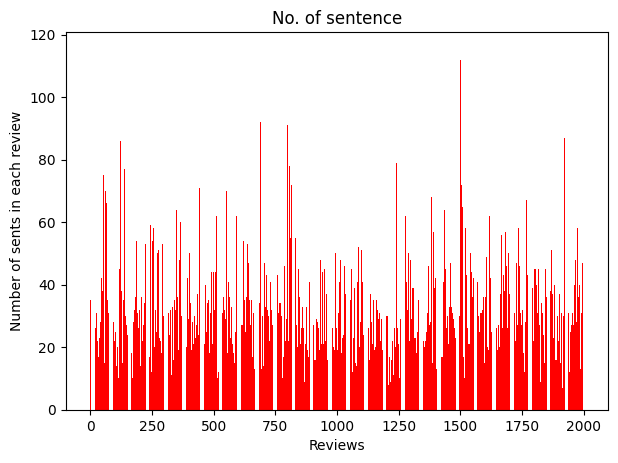

In [15]:
#see number of sentences to choose the N value 

import matplotlib.pyplot as plt
%matplotlib inline

#print graph with number of sentence per review
len_sent = [len(sent) for sent in (neg_reviews+pos_reviews)]
print(len(len_sent))

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(len(len_sent)), len_sent, color = ['red'])
plt.gca().set(title='No. of sentence', xlabel='Reviews', ylabel='Number of sents in each review');


###Define the N-best sentences

The value N is define a priori by observing the best results. If we set it as a costant then N = 20-best subjective sentences; otherwise, it can be set to a percentage and keep for each review a number of sentences relative to their length. The results almost similar with N = 60%.

In [16]:
#Subjectivity detection

#prepare all dataset to the subjectivty detector
neg_review_subj = []
pos_review_subj = []

#number of sentences to choose
#60% with local = 1 is best , 20 sents with local = 0 also
N = 60

#local = 0 choose a constant variable equal for all the reviews, 
#in this case control the graph below to choose the appropriate value
#local = 1 choose a percentage value equal for all the reviews
#no need to know the exact number of sentences inside a review
local = 1

#negative reviews
start_execution = time.time()
print("-----------------------------------------------------------------------")
i=0
for review in neg_reviews:
  start_time = time.time() 
  i+=1
  print("Review no. %s" % (i))
  neg_review_subj.append(subj_filtering(review,N,local,filename, vectorizer))
  print("------------------- %s seconds ------------------------" % (time.time() - start_time))
print("Total time: %s" % (time.time() - start_execution))

#positive reviews
start_execution = time.time()
print("-----------------------------------------------------------------------")
i=0
for review in pos_reviews:
  start_time = time.time() 
  i+=1
  print("Review no. %s" % (i))
  pos_review_subj.append(subj_filtering(review,N,local,filename, vectorizer))
  print("------------------- %s seconds ------------------------" % (time.time() - start_time))
print("Total time: %s" % (time.time() - start_execution))

Output streaming troncato alle ultime 5000 righe.
------------------- 0.07406091690063477 seconds ------------------------
Review no. 168
detecting...
Classes:  ['obj' 'subj']
Scores assigned
Choose 60% of sentences inside each review 
------------------- 0.06912589073181152 seconds ------------------------
Review no. 169
detecting...
Classes:  ['obj' 'subj']
Scores assigned
Choose 60% of sentences inside each review 
------------------- 0.04677104949951172 seconds ------------------------
Review no. 170
detecting...
Classes:  ['obj' 'subj']
Scores assigned
Choose 60% of sentences inside each review 
------------------- 0.09646248817443848 seconds ------------------------
Review no. 171
detecting...
Classes:  ['obj' 'subj']
Scores assigned
Choose 60% of sentences inside each review 
------------------- 0.033493995666503906 seconds ------------------------
Review no. 172
detecting...
Classes:  ['obj' 'subj']
Scores assigned
Choose 60% of sentences inside each review 
-------------------

2000


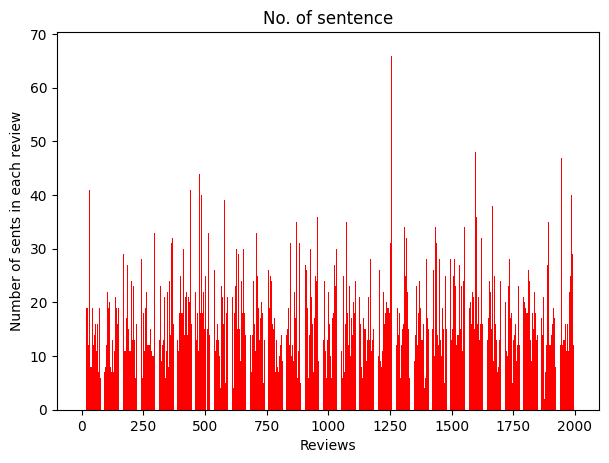

In [17]:
#plot no. sentences after subjectivity detection

%matplotlib inline

#print graph with number of sentence per review
len_sent_subj = [len(sent) for sent in (neg_review_subj+pos_review_subj)]
print(len(len_sent))

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(len(len_sent_subj)), len_sent_subj, color = ['red'])
plt.gca().set(title='No. of sentence', xlabel='Reviews', ylabel='Number of sents in each review');

#Polarity Classification

This task is performed on the new dataset without the objective sentences.The classifier model was trained on the train set represented by 80% of the movie reviews and tested on the remain 20% (also the cross-validation was performed). The entire filtered review was given to perform the feature extraction at the document-level.

Different models were tested:


*   NaiveBayes
*   SVM
*   LogisticRegression

Different vectors type were used:


*   CountVectorizer
*   TfidfVectorizer

Considering time of execution and accuracy, the best performance is given by the Naive Bayes model using the Tfidf vectorizer, which considers not only unigrams but also bigrams and trigrams.






In [18]:
#Polarity classification of clean and subjective text

print(len(neg_review_subj), len(pos_review_subj))

neg_docs_subj = [(neg_review_subj[i],'neg') for i in range(len(neg_review_subj))]
pos_docs_subj = [(pos_review_subj[i],'pos') for i in range(len(pos_review_subj))]

X_train, X_test, y_train, y_test = data_split(1000, neg_docs_subj, pos_docs_subj)

#print classification of 80train/20test for each vector type and for Bayes and svm
print("---------------------------------------------")
start_time = time.time()
vector = 0

for i in range(2):  
  #print cross-validation for each classifier using TF-IDF and CountVectorizer extractor
  vector = i
  print("################################################################")
  print("TRAIN 80 TEST 20")
  start_time = time.time()
  subjectivity_detector(X_train,X_test, y_train, y_test, vector,ngrams)
  print("------------------- %s seconds ------------------------" % (time.time() - start_time))
  print("################################################################")

  print("----------------------------------------------------------------")
  print("USING CROSS VALIDATION")
  start_time = time.time()
  print("Multinomial NaiveBayes")
  model = MultinomialNB()
  subjectivity_detector_cross_val(X_train, X_test, y_train, y_test, vector, model,ngrams)
  print("------------------- %s seconds ------------------------" % (time.time() - start_time))

  print("Linear SVM")
  start_time = time.time()
  model = svm.SVC(kernel='linear', gamma='auto', probability=True)
  subjectivity_detector_cross_val(X_train, X_test, y_train, y_test, vector, model,ngrams)
  print("------------------- %s seconds ------------------------" % (time.time() - start_time))

  print("----------------------------------------------------------------")
  print("LogisticRegression")
  start_time= time.time()
  model = LogisticRegression(max_iter=1000)
  subjectivity_detector_cross_val(X_train, X_test, y_train, y_test, vector, model, ngrams)
  print("------------------- %s seconds ------------------------" % (time.time() - start_time))
  print("************************************************vector test end**********************************************************")



1000 1000
---------------------------------------------
################################################################
TRAIN 80 TEST 20
Naive Bayes Accuracy Score ->  86.5
{'neg': {'precision': 0.8724489795918368, 'recall': 0.855, 'f1-score': 0.8636363636363636, 'support': 200}, 'pos': {'precision': 0.8578431372549019, 'recall': 0.875, 'f1-score': 0.8663366336633663, 'support': 200}, 'accuracy': 0.865, 'macro avg': {'precision': 0.8651460584233693, 'recall': 0.865, 'f1-score': 0.864986498649865, 'support': 400}, 'weighted avg': {'precision': 0.8651460584233693, 'recall': 0.865, 'f1-score': 0.864986498649865, 'support': 400}}
------------------- 0.0543820858001709 seconds ------------------------
--------------------------------------
SVM Accuracy Score ->  88.75
{'neg': {'precision': 0.8817733990147784, 'recall': 0.895, 'f1-score': 0.8883374689826302, 'support': 200}, 'pos': {'precision': 0.8934010152284264, 'recall': 0.88, 'f1-score': 0.8866498740554157, 'support': 200}, 'accuracy':